# <span style="color:green"> Numerical Simulation Laboratory: Numerical Exercises 4 </span>
### <span style="color:royalblue"> Comment on the C++ code - Usage </span>
The C++ programs can be compiled by means of a makefile, which produces the executable **main.exe**. One could also compile and launch directly using the command **make all** or clean the existing output and .o files using **make clean**.<br>
The programs prints on screen the relevant parameters and the equilibration/simulation cycles performed. It also asks whether the configuration files **old.0** and **old.final** shall be overwritten. The output data (observables, frames with the xyz configurations) are saved in the folder OutputData, while the configuration and input files are saved in the same folder of **main.cpp**.<br>
The **main** function allows to repeat multiple calculations without needing to launch again the program. In particular, one could modify the **input.dat** file (thus altering arbitrarily the parameters of the system) and start another simulation without exiting the program. This file has the following structure:
###### Simulation parameters ######
108$\quad$ Number of particles (108)<br>
10000$\quad$ Simulation Steps<br>
0	$\quad$ Frame output frequency (it should be a divisor of the number of Simulation Steps) [if 0, output disabled]<br>
10		$\quad$ Measure output frequency (it should be a divisor of the number of Simulation Steps) [if 0, output disabled]<br>
100		$\quad$ Number of Blocks (data blocking for the output measures. This *must* be a divisor of Nsteps/MeasureFrequency = Nmeasures)<br>
1000	$\quad$ Current step (screen output) frequency 
###### Equilibration cycles ######
20		$\quad$ Number of equilibration cycles<br>
500		$\quad$ Number of steps of each cycle (using the method Move())
###### System parameters ######
1.2	$\quad$ Temperature<br>
0.05$\quad$ Density<br>
5.0	$\quad$ Cutoff radius<br>
0.005$\quad$ Delta t
###### Other options ######
true $\quad$ If *true*, read two spatial configurations at times $t-dt$, $t$ (respectively from the files **old.0** and **old.final**). If *false*, read the initial configuration from "config.0" and set random speeds<br><br>
The fundamental aspect of this file is that it can be modified arbitrarily, with the exception that **the number of lines should not be varied. Also, the spacing between numbers and text does not matter, however it cannot be completely removed**. The justification for these requirements can be found in the function **Input(...)** contained in **main.cpp**.<br>
In **Exercise 04.3** further explanations of the files **solid.sh**, **liquid.sh** and **gas.sh** will be given.

### <span style="color:royalblue"> Comment on the C++ code - Structure </span>
The C++ program is based on the class **MolDyn** (moldyn.h, moldyn.cpp), whose main features are:
- Data
    1. The arrays X, Xold, V, which represent the actual and old configurations of particles, together with their instantaneous speed;
    2. The system parameters (density, target temperature...) and the instantaneous values of the observables (kinetic, potential and total energy, temperature);
    3. The progressive values of the aforementioned observables. These are stored in the objects **Stat** (stat.h, stat.cpp), which implement the statistical blocking methods.
- Methods
    1. Various constructors, set and get methods;
    2. Set/Output functions which read from and save on file the configurations
    3. The **Equilibrium** function, which performs the equilibration cycles (decided by means of the file input.dat);
    4. The **Move** function, which simply translates the particles using the Lennard-Jones potential and the **Simulate** function, which repeats many steps.
    5. **Simulate** also contains the methods which allow to measure and save on file the observables (instantaneous values).

## <span style="color:royalblue"> Comment on the Python code </span>
We define here the functions that gather the bulky code, with the aim of making the plots easier to visualize and compare.<br>
**ReadParam** reads the file **input.dat** and returns the main parameters of the system.<br>
**ReadEquilibration** reads the file **EQ.out**, which contains the values of $T$ achieved during the equilibration process. <br>
**ReadInstantaneous** reads the files **(name).dat** containing the observables' *instantaneous* values. <br>
**ReadProgressive** reads the files **(name)\_prog.dat** containing the observables' *progressive averages*.<br>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def ReadParam(filename, add_string):
    with open("Esercizio04.1/"+add_string+filename) as file:
        # Simulation parameters
        file.readline().split()
        Input = [int(file.readline().split()[0]) for i in range(6)]
        Npart, Nsteps, Nframes, Fmeasures, Nblocks = Input[0:5]
        if (Nframes!=0): Nframes = int(Nsteps/Nframes) # Conversion from a frequency to a total count
        if (Fmeasures!=0): Nmeasures = int(Nsteps/Fmeasures) # Conversion from a frequency to a total count
        # Equilibration parameters
        file.readline().split()
        Input = [int(file.readline().split()[0]) for i in range(2)]
        NcyclesEQ, NstepsEQ = Input[0:2]
        # System parameters
        file.readline().split()
        Input = [float(file.readline().split()[0]) for i in range(4)]
        T, Rho, Rcut, dt = Input[0:4]
    return Npart, Nsteps, Nframes, Fmeasures, Nmeasures, Nblocks, NcyclesEQ, NstepsEQ, T, Rho, Rcut, dt

def ReadEquilibration(filename, add_string):
    with open("Esercizio04.1/"+add_string+filename) as file:
        file.readline()
        T_array = []
        for line in file:
            T_array.append(float(line.split()[1]))
    return T_array

def ReadInstantaneous(filename, add_string):
    Obs = [[] for i in range(len(filename))]
    for i in range(len(filename)):
        with open("Esercizio04.1/"+add_string+filename[i]+".dat") as file:
            for line in file:
                Obs[i].append(float(line))
    return Obs

def ReadProgressive(filename, add_string):
    Obs = [[[]for i in range(2)] for i in range(len(filename))]
    for i in range(len(filename)):
        with open("Esercizio04.1/"+add_string+filename[i]+"_prog.dat") as file:
            for line in file:
                average, sigma = line.split()
                Obs[i][0].append(float(average))
                Obs[i][1].append(float(sigma))
    return Obs

def PlotInstantaneous(Nsteps, Nmeasures, Fmeasures, Obs, T_target, Rho, Rcut, Labels):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
    ax = ax.flatten()
    fig.suptitle(f"Simulation - Instantaneous values [{Nsteps} steps, {Nmeasures} measures, "+r"$\rho$"+
                 f" = {Rho}, Rcut = {Rcut}]", y = 1.01, fontsize=16)
    for i in range(len(Obs)):
        if (i!=3):
            ax[0].plot(np.arange(1, (len(Obs[i]))*Fmeasures+1, Fmeasures), Obs[i], label=Labels[i])
            ax[0].legend(prop={"size":14})
        if (i==3):
            ax[1].plot(np.arange(1, (len(Obs[i]))*Fmeasures+1, Fmeasures), Obs[i], label=Labels[i], color="black")
            ax[1].plot([1, len(Obs[i])*Fmeasures], [T_target, T_target], label="Target temperature", color="tab:red")
            ax[1].legend(prop={"size":12})

    ax[0].set_xlabel("Simulation steps", fontsize=14)
    ax[0].set_ylabel("Energy [*10^-21 J]", fontsize=14)
    ax[0].set_title("Energy as a function of the simulation steps", fontsize=14)
    ax[1].set_xlabel("Simulation steps", fontsize=14)
    ax[1].set_ylabel("Temperature [K]", fontsize=14)
    ax[1].set_title("Temperature as a function of the simulation steps", fontsize=14)

def PlotProgressive(Nsteps, Nmeasures, Fmeasures, Obs, T_target, Rho, Rcut, Labels, Ecolors, Ylabels):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
    ax = ax.flatten()
    fig.subplots_adjust(hspace=0.20, wspace=0.27)
    fig.suptitle(f"Simulation - Progressive averages and errors  "+
                 f"[{Nsteps} steps, {Nmeasures} measures, {Nblocks} blocks, "+r"$\rho$"+
                 f" = {Rho}, Rcut = {Rcut}]", y = 0.93, fontsize=16)
    for i in range(len(Obs)):
        ax[i].errorbar(np.arange(1, len(Obs[i][0])+1), Obs[i][0], yerr=Obs[i][1], color="black", 
                       ecolor=Ecolors[i], label=Labels[i])
        ax[i].set_xlabel("Blocks", fontsize=12)
        ax[i].set_ylabel(Ylabels[i], fontsize=12)
        ax[i].grid(True)
        if (i==3):
            ax[i].plot([1, len(Obs[i][0])], [T_target, T_target], color="tab:red", label="Target Temperature")
        ax[i].legend(prop={"size":16})

# Exercise 04.1, 04.2
Since these two steps of exercise 4 do not require any visual representation, this section is only an "environment" which enables to visualize the output produced by the C++ program. Once these outputs are considered valid, the content of the folder **OutputData** can be copied and moved to the **folders** **"solid"**, **"liquid"** and **"gas"**, which contain the definitive data for the Argon simulations of **Exercise04.3**. Further explanations are given in the following section.

We now read the parameters used in the last simulation from **input.dat**. The list Filenames contains the (partial) names of the files: the instantaneous values are found in (filename)+".out", while the progressive average are saved on (filename)+"_prog.out"

In [2]:
Filenames = ["output_ekin", "output_epot", "output_etot", "output_temp"]
Labels = ["Kinetic energy", "Potential energy", "Total energy", "Temperature"]
Ylabels = ["Kinetic energy K [LJ units]", "Potential energy U [LJ units]", "Total energy E [LJ units]",
           "Temperature T [LJ units]"]
Ecolors = ["tab:green", "tab:red", "tab:orange", "tab:blue"]
# Read the fundamental parameters of the system
Npart,Nsteps,Nframes,Fmeasures,Nmeasures,Nblocks,NcyclesEQ,NstepsEQ,T_target,Rho,Rcut,dt= ReadParam("input.dat","")

We then represent the plot of the last values of temperature measured at the end of each equilibration cycles.<br>

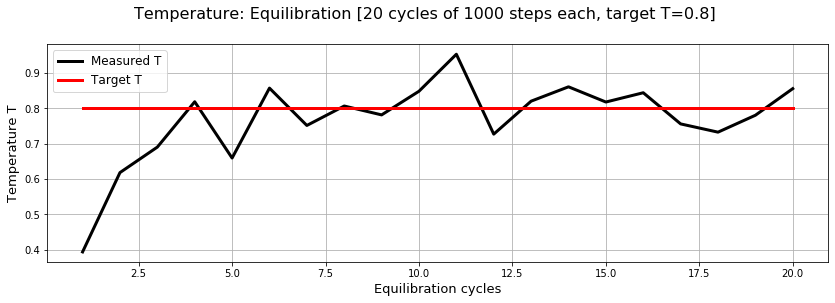

In [3]:
# Read from file
T_array = ReadEquilibration("EQ.out", "OutputData/") # Equilibrium cycles
# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,4))
#ax = ax.flatten()
fig.suptitle(f"Temperature: Equilibration [{NcyclesEQ} cycles of {NstepsEQ} steps each, target T={T_target}]",
             y = 1.01, fontsize=16)
if (T_array!=[]): ax.plot(np.arange(1, len(T_array)+1), T_array, color='black', linewidth=3, label="Measured T")
ax.plot([1, (len(T_array))], [T_target, T_target], color="red", linewidth=3, label="Target T")
ax.set_ylabel("Temperature T", fontsize=13)
ax.set_xlabel("Equilibration cycles", fontsize=13)
ax.grid(True)
ax.legend(prop={"size":12})
plt.show()

### <span style="color:firebrick"> Instantaneous values of the observables </span>
The following plots represent the instantaneous values of the variables as a function of the simulation steps. In general, the total energy $E$ exhibits a much greater stability than the two partial energies $K, U$. For a suitable choice of equilibration/simulation parameters, the temperature $T$ oscillates around the target value. This is true especially in the case of a solid or a liquid, while for the gas phase the displacement between target temperature and measured value can be more significant.

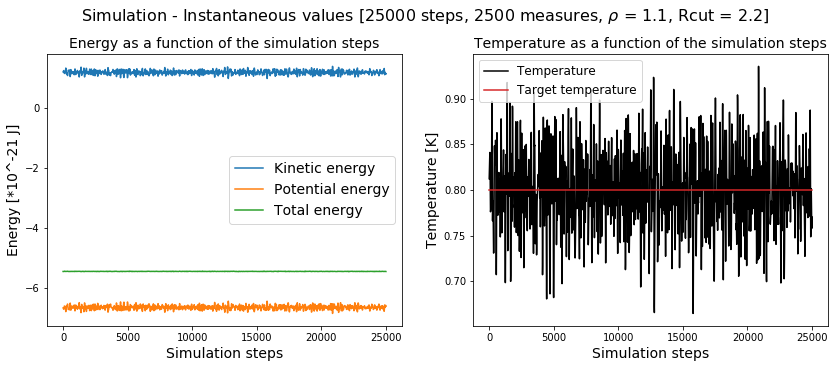

In [4]:
# Observables: read from file
K, U, E, T = ReadInstantaneous(Filenames, "OutputData/")
Obs = [K, U, E, T] # Observables: Kinetic energy, Potential energy, Total energy, Temperature

# Plots
PlotInstantaneous(Nsteps, Nmeasures, Fmeasures, Obs, T_target, Rho, Rcut, Labels)
plt.show()

### <span style="color:firebrick">  Progressive averages and errors of the observables</span>
The progressive averages and errors are computed via the statistical blocking method. This enables to achieve a greater stability around an estimated value. We now represent these progressive average of the variables as a function of the number of blocks (which are as always set in the file **input.dat**). The total energy $E$ plot might appear discontinuous due to the floating point approximations (indeed, $E$ usually quickly stabilizes with small oscillations). In general the gas phase seems the most difficult phase to compute, as the number of equilibration and simulation cycles required to achieve the desired stability in the observable values is higher than in the liquid and solid cases. Also, the final values of $T$ can fall off the interval $[T-\sigma, T+\sigma]$. <br>
Nevertheless, we suggest a strategy which seems to improve the results: performing one "standard" cycle (equilibration + simulation, starting from "config.0" or with a compatible old configuration), followed by one long simulation cycle (ignoring the equilibration process, setting $N_{cycles} = 0$ in the equilibration section of **input.dat** and using the **old configurations old.0 and old.final**) gives better results. These long simulation cycles can be repeated _ad libitum_ until a consistent set of observables is obtained.

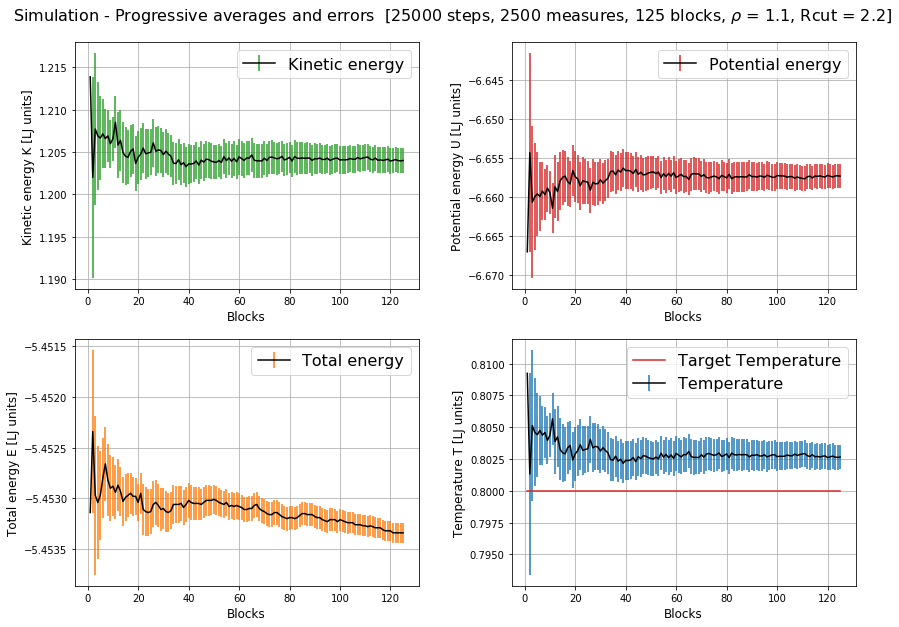

In [5]:
# Read from file The progressive values of the observables
K, U, E, T = ReadProgressive(Filenames, "OutputData/")
Obs = [K, U, E, T] # Progressive values, each in the form [average(array), sigma(array)] 

# Plots
PlotProgressive(Nsteps, Nmeasures, Fmeasures, Obs, T_target, Rho, Rcut, Labels, Ecolors, Ylabels)
plt.show()

# Exercise 04.3
We now present the simulations of the three phases of Argon, namely:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

The data can be found in the folders **"solid"**, **"liquid"** and **"gas"**, which are not affected by the C++ program (invoking **make clear** preserves these folders, since it acts only on **OutputData**, that contains the new and temporary output). 

**[IMPORTANT]** If a new solid/liquid/gas simulation is performed and is considered definitive, in order to represent it all the content of the folder _OutputData_ must be copied to the corresponding folder, otherwise it will be showed only by the previous jupyter section (*Exercise 04.1, 04.2*). The file _input.dat_ shall also be included. <span style="color:firebrick"> This operations can be achieved by executing the corresponding bash files **solid.sh**, **liquid.sh** or **gas.sh** (which also copy the folder **frames**, unused by this jupyter notebook)

### <span style="color:orangered"> Conversion and Plot functions </span>

In [6]:
# Lennard Jones units - SI units scaling factors
import math
sigma = 3.4 # * 10^-10 m
epsilon = 1.657 # * 10^-21 J
m = 6.686 # * 10^-26 Kg
tau = 120 # K, Temperature scaling

Filenames = ["output_ekin", "output_epot", "output_etot", "output_temp"]
Labels = ["Kinetic energy", "Potential energy", "Total energy", "Temperature"]
Ylabels = ["Kinetic energy K [*10^-21 J]", "Potential energy U [*10^-21 J]", "Total energy E [*10^-21 J]",
           "Temperature T [K]"]
Ecolors = ["tab:green", "tab:red", "tab:orange", "tab:blue"]

def ConvertUnitsInst(Obs):
    for i in range(len(Obs)-1):
        for j in range(len(Obs[i])): # Energy
            Obs[i][j] *= epsilon
    for j in range(len(Obs[3])): # Temperature
            Obs[3][j] *= tau
    return Obs
            
def ConvertUnitsProg(Obs):
    for i in range(len(Obs)-1):
        for j in range(len(Obs[i][0])): # Energy
            Obs[i][0][j] *= epsilon
            Obs[i][1][j] *= epsilon
    for j in range(len(Obs[3][0])): # Temperature
            Obs[3][0][j] *= tau
            Obs[3][1][j] *= tau
    return Obs

## <span style="color:orangered"> Solid phase </span>
The total energy $E$ plot shows that the algorithm is particularly effective from the point of view of energy conservation. In fact, the oscillations of $U$ and $K$ counteract each other nearly in an exact way. This might not be evident at first, since $E$ is affected only by small oscillations and consequently the $y$ axis scale is greatly magnified. <br>
However, the temperature plot shows that even if the algorithm reaches a stable value of $T$, this value falls off the interval $[T-\sigma, T+\sigma]$. This is a consequence of the nature of the algorithm, which has poor control on the temperature of the system. Overall, the results seem consistent with the expectations. <br>

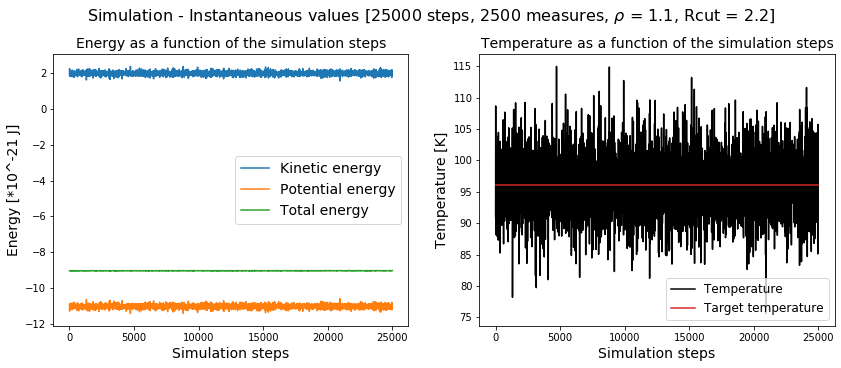

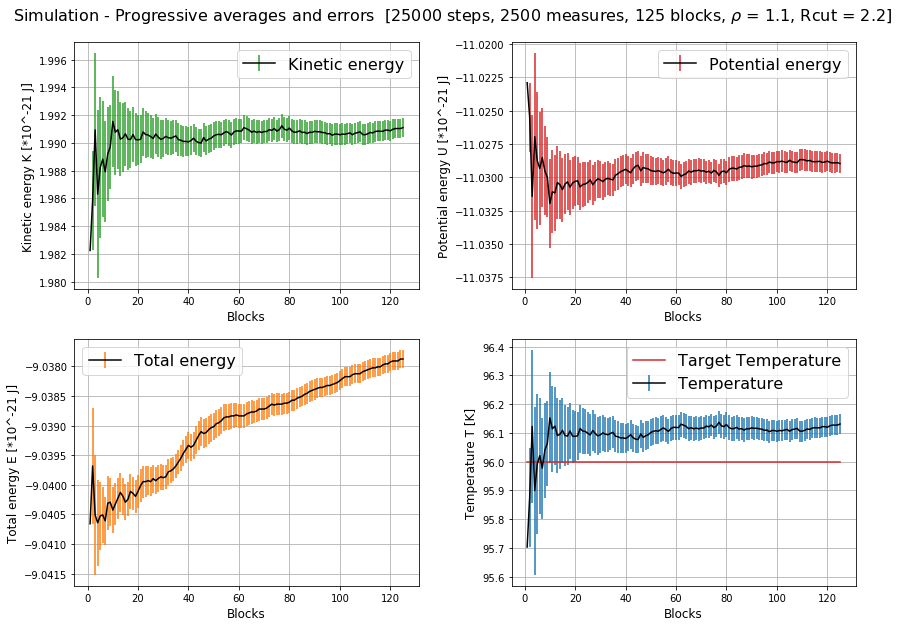

In [7]:
# Read parameters
Npart,Nsteps,Nframes,Fmeasures,Nmeasures,Nblocks,_,_,T_target,Rho,Rcut,dt= ReadParam("input.dat","solid/")
T_target *= tau
# Instantaneous values
K, U, E, T = ReadInstantaneous(Filenames, "solid/")
Obs = [K, U, E, T]
Obs = ConvertUnitsInst(Obs)
PlotInstantaneous(Nsteps, Nmeasures, Fmeasures, Obs, T_target, Rho, Rcut, Labels)
# Progressive values
K, U, E, T = ReadProgressive(Filenames, "solid/")
Obs = [K, U, E, T]
Obs = ConvertUnitsProg(Obs)
PlotProgressive(Nsteps, Nmeasures, Fmeasures, Obs, T_target, Rho, Rcut, Labels, Ecolors, Ylabels)

## <span style="color:orangered"> Liquid phase </span>
The measurements relative to the liquid phase are similar to those of the solid phase previously considered. Indeed, even if $T$ and the density $\rho$ are different, the behaviour of the observables is comparable; the instantaneous values of total energy $E$ are particularly stable (this can be also said of the progressive averages of $K$, $U$ and $T$), while the average $T$ is more than one $\sigma$ from the target value. As before, this shows that the algorithm has a poor control of the temperature, but leaves the total energy almost unchanged.

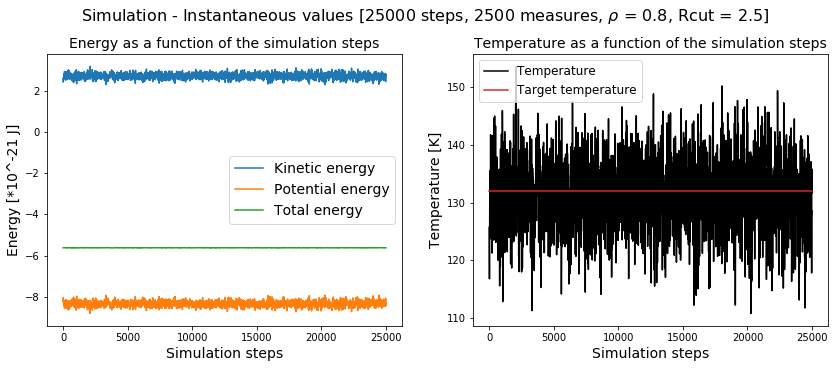

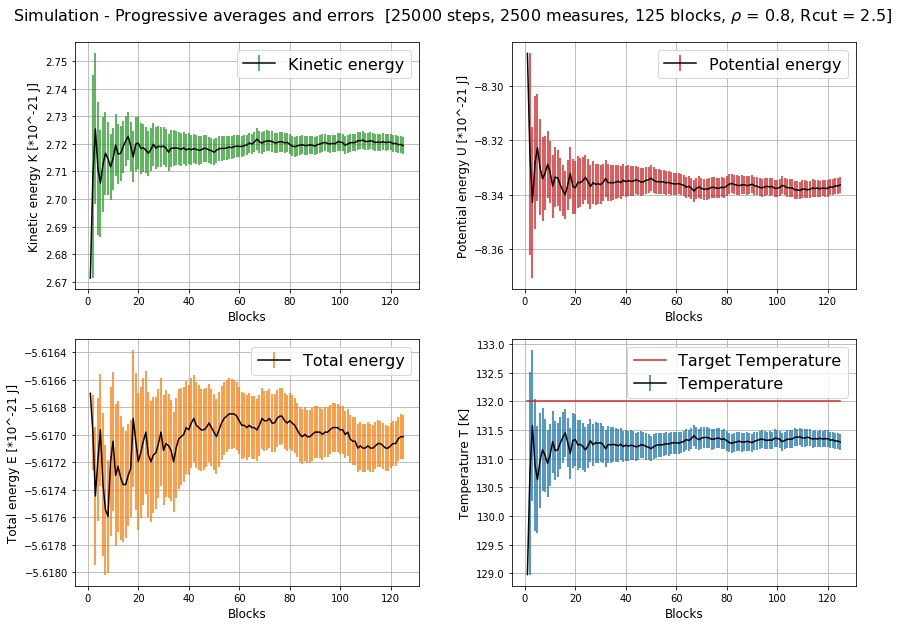

In [8]:
# Read parameters
Npart,Nsteps,Nframes,Fmeasures,Nmeasures,Nblocks,_,_,T_target,Rho,Rcut,dt= ReadParam("input.dat","liquid/")
T_target *= tau
# Instantaneous values
K, U, E, T = ReadInstantaneous(Filenames, "liquid/")
Obs = [K, U, E, T]
Obs = ConvertUnitsInst(Obs)
PlotInstantaneous(Nsteps, Nmeasures, Fmeasures, Obs, T_target, Rho, Rcut, Labels)
# Progressive values
K, U, E, T = ReadProgressive(Filenames, "liquid/")
Obs = [K, U, E, T] 
Obs = ConvertUnitsProg(Obs)
PlotProgressive(Nsteps, Nmeasures, Fmeasures, Obs, T_target, Rho, Rcut, Labels, Ecolors, Ylabels)

## <span style="color:orangered"> Gas phase </span>
The gas phase turns out to be the most difficult phase to compute. Indeed, the measured temperature (and thus the correlated values of $K$ and $U$) has a less stable behaviour and suffers from some important oscillations that cannot be controlled by the algorithm. This can be seen on both the individual values' plot and the progressive average's plot, especially if compared to the corresponding graphs of the solid and liquid phase. Nevertheless, with a suitable choice of initial data, the final results prove to be consistent with the expected values. The algorithm proves to be particularly effectove in keeping the value of the total energy $E$ stable, since the fluctuations of $U$ and $K$ counteract each other.

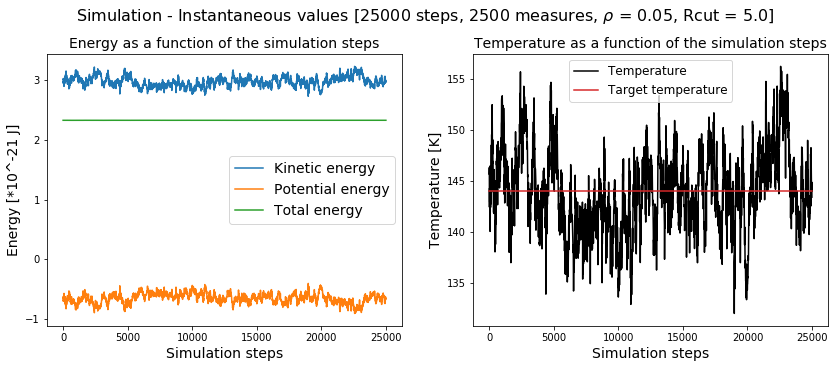

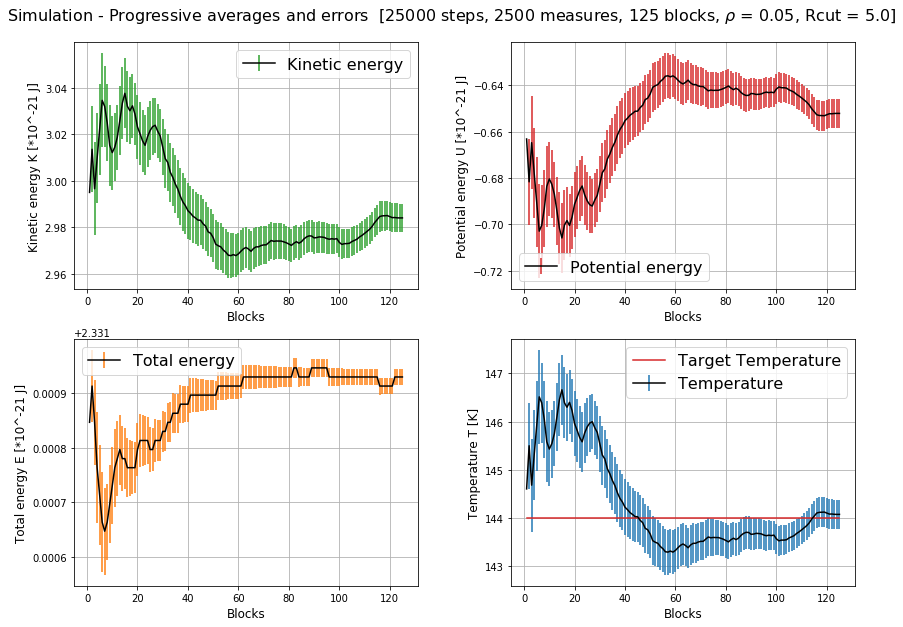

In [9]:
# Read parameters
Npart,Nsteps,Nframes,Fmeasures,Nmeasures,Nblocks,_,_,T_target,Rho,Rcut,dt= ReadParam("input.dat","gas/")
T_target *= tau
# Instantaneous values
K, U, E, T = ReadInstantaneous(Filenames, "gas/")
Obs = [K, U, E, T]
Obs = ConvertUnitsInst(Obs)
PlotInstantaneous(Nsteps, Nmeasures, Fmeasures, Obs, T_target, Rho, Rcut, Labels)
# Progressive values
K, U, E, T = ReadProgressive(Filenames, "gas/")
Obs = [K, U, E, T] 
Obs = ConvertUnitsProg(Obs)
PlotProgressive(Nsteps, Nmeasures, Fmeasures, Obs, T_target, Rho, Rcut, Labels, Ecolors, Ylabels)